In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from itertools import product
import json
import yaml
import intake
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt

import funnel
import data_collections as dc
import operators as ops
import util

import pop_tools

import traits_db
import metabolic as mi

Modify `groupby_attrs` to remove `member_id` so that that ends up as a dimension in the datasets.

In [3]:
try:
    cluster
    client
except:
    cluster, client = util.get_ClusterClient(memory='100GB')
    cluster.scale(34)
client    

/glade/work/mclong/miniconda3/envs/metabolic/lib/python3.7/site-packages/distributed/node.py:161: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 40105 instead
  f"Port {expected} is already in use.\n"


Connection method: Cluster object,Cluster type: PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mclong/calcs/proxy/40105/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mclong/calcs/proxy/40105/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.59:34937,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mclong/calcs/proxy/40105/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [4]:
catalog_json_file = funnel.to_intake_esm(agg_member_id=True)

In [5]:
sub_spec = dict(
    name='drift-corrected',
    experiment=['20C', 'RCP85'],
    member_id=dc.ocean_bgc_member_ids,
)


catalog = funnel.to_intake_esm(agg_member_id=True).search(**sub_spec)
catalog

,unique
experiment,2
component,1
stream,1
member_id,1
variable,6
name,1
path,12


In [7]:
cat_keys = ['20C.ocn.pop.h.drift-corrected', 'RCP85.ocn.pop.h.drift-corrected']
variables = ['O2', 'pO2', 'TEMP', 'O2_CONSUMPTION', 'O2_PRODUCTION'] #'Jint_100m_DIC', 'photoC_sp', 'photoC_diat', 'photoC_diaz']

for v in variables:
    dsets = catalog.search(member_id=2, variable=v).to_dataset_dict()

    ds = xr.concat([dsets[k].isel(z_t=slice(0, 10)) for k in cat_keys], dim='time')
    ds.time.encoding = dsets['20C.ocn.pop.h.drift-corrected'].time.encoding
    ds.time_bound.encoding = dsets['20C.ocn.pop.h.drift-corrected'].time_bound.encoding

    ds.to_netcdf(f'/glade/scratch/mclong/cesm-le.o2-vars.{v}.192001-210012.nc')


--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.name'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.name'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.name'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.name'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.name'


In [ ]:
grid = pop_tools.get_grid('POP_gx1v6')

/glade/work/mclong/miniconda3/envs/metabolic/lib/python3.7/site-packages/numba/np/ufunc/parallel.py:365: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 6103. The TBB threading layer is disabled.
  warnings.warn(problem)


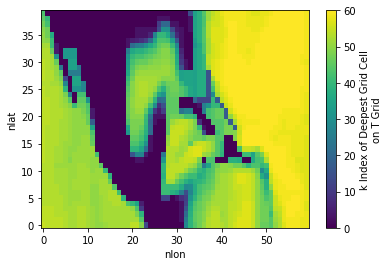

In [8]:
grid.KMT.isel(nlat=slice(240, 280), nlon=slice(250, 310)).plot()

In [9]:
def subset_point(ds):
    return ds.isel(z_t=0, nlat=260, nlon=295)

In [10]:
dsets = catalog.search(variable=['TEMP', 'pO2']).to_dataset_dict()
dsets


--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.name'


{'20C.ocn.pop.h.drift-corrected': <xarray.Dataset>
 Dimensions:     (member_id: 33, nlat: 384, nlon: 320, time: 1032, z_t: 40, d2: 2, z_t_150m: 15)
 Coordinates:
   * member_id   (member_id) int64 2 9 10 11 12 13 14 ... 35 101 102 103 104 105
     KMT         (nlat, nlon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
     TAREA       (nlat, nlon) float64 1.125e+13 1.125e+13 ... 7.431e+12 7.432e+12
     TLAT        (member_id, nlat, nlon) float64 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
     TLONG       (member_id, nlat, nlon) float64 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
     ULAT        (nlat, nlon) float64 -78.95 -78.95 -78.95 ... 72.42 72.41 72.41
     ULONG       (nlat, nlon) float64 321.1 322.3 323.4 ... 319.2 319.6 320.0
     dz          (z_t) float32 1e+03 1e+03 1e+03 ... 9.844e+03 1.133e+04
   * time        (time) object 1920-01-17 00:29:59.999993 ... 2005-12-16 12:00:00
     time_bound  (time, d2) object 1920-01-02 00:59:59.999997 ... 2006-01-0

In [11]:
dsets2 = {key: subset_point(ds) for key, ds in dsets.items()}
dsets2

{'20C.ocn.pop.h.drift-corrected': <xarray.Dataset>
 Dimensions:     (member_id: 33, time: 1032, d2: 2, z_t_150m: 15)
 Coordinates:
   * member_id   (member_id) int64 2 9 10 11 12 13 14 ... 35 101 102 103 104 105
     KMT         float64 59.0
     TAREA       float64 5.527e+13
     TLAT        (member_id) float64 dask.array<chunksize=(1,), meta=np.ndarray>
     TLONG       (member_id) float64 dask.array<chunksize=(1,), meta=np.ndarray>
     ULAT        float64 21.63
     ULONG       float64 293.1
     dz          float32 1e+03
   * time        (time) object 1920-01-17 00:29:59.999993 ... 2005-12-16 12:00:00
     time_bound  (time, d2) object 1920-01-02 00:59:59.999997 ... 2006-01-01 0...
     z_t         float32 500.0
   * z_t_150m    (z_t_150m) float32 500.0 1.5e+03 2.5e+03 ... 1.35e+04 1.45e+04
 Dimensions without coordinates: d2
 Data variables:
     TEMP        (member_id, time) float64 dask.array<chunksize=(1, 12), meta=np.ndarray>
     pO2         (member_id, time) float64 dask.ar

In [12]:
ds = xr.concat((dsets2['20C.ocn.pop.h.drift-corrected'], dsets2['RCP85.ocn.pop.h.drift-corrected']), dim='time').compute()
ds

<xarray.Dataset>
Dimensions:     (member_id: 33, time: 2172, d2: 2, z_t_150m: 15)
Coordinates:
  * member_id   (member_id) int64 2 9 10 11 12 13 14 ... 35 101 102 103 104 105
    KMT         float64 59.0
    TAREA       float64 5.527e+13
    TLAT        (member_id) float64 21.42 21.42 21.42 ... 21.42 21.42 21.42
    TLONG       (member_id) float64 292.5 292.5 292.5 ... 292.5 292.5 292.5
    ULAT        float64 21.63
    ULONG       float64 293.1
    dz          float32 1e+03
  * time        (time) object 1920-01-17 00:29:59.999993 ... 2100-12-16 12:00:00
    time_bound  (time, d2) object 1920-01-02 00:59:59.999997 ... 2101-01-01 0...
    z_t         float32 500.0
  * z_t_150m    (z_t_150m) float32 500.0 1.5e+03 2.5e+03 ... 1.35e+04 1.45e+04
Dimensions without coordinates: d2
Data variables:
    TEMP        (member_id, time) float64 25.38 24.95 24.72 ... 29.86 29.52
    pO2         (member_id, time) float64 21.19 21.31 21.31 ... 21.26 21.2 21.19
Attributes: (12/13)
    calendar:                  All years have exactly  365 days.
    tavg_sum_qflux:            2592000.0
    source:                    CCSM POP2, the CCSM Ocean Component
    tavg_sum:                  2592000.0
    intake_esm_varname:        TEMP\npO2
    revision:                  $Id: tavg.F90 41939 2012-11-14 16:37:23Z mlevy...
    ...                        ...
    Conventions:               CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netc...
    cell_methods:              cell_methods = time: mean ==> the variable val...
    history:                   none\nTue Sep 10 06:07:07 2013: /glade/apps/op...
    contents:                  Diagnostic and Prognostic Variables
    nsteps_total:              750
    intake_esm_dataset_key:    20C.ocn.pop.h.drift-corrected

In [13]:
from collections.abc import Iterable
import cftime

def to_datenum(y, m, d, time_units='days since 0001-01-01 00:00:00'):
    """convert year, month, day to number"""      
    return cftime.date2num(cftime.datetime(y, m, d), units=time_units)

def nday_per_year(year):
    return 365


def year_frac(year, month, day):
    """compute year fraction"""
    if isinstance(year, Iterable):
        assert isinstance(month, Iterable)
        assert isinstance(day, Iterable)
        t0_year = np.array([to_datenum(y, 1, 1) - 1 for y in year])
        t_year = np.array([to_datenum(y, m, d) for y, m, d in zip(year, month, day)])
        nday_year = np.array([nday_per_year(y) for y in year])
    else:
        t0_year = to_datenum(year, 1, 1) - 1
        t_year = to_datenum(year, month, day)
        nday_year = nday_per_year(year)
    
    return year + (t_year - t0_year) / nday_year

year = [d.year for d in ds.time.values]
month = [d.month for d in ds.time.values]
day = [d.day for d in ds.time.values]
yrfrac = year_frac(year, month, day)
yrfrac

array([1920.04657534, 1920.1260274 , 1920.20821918, ..., 2100.79178082,
       2100.87671233, 2100.95890411])

In [22]:
tnx = np.where(yrfrac > 1950)[0]

Text(0, 0.5, 'Temperature [°C]')

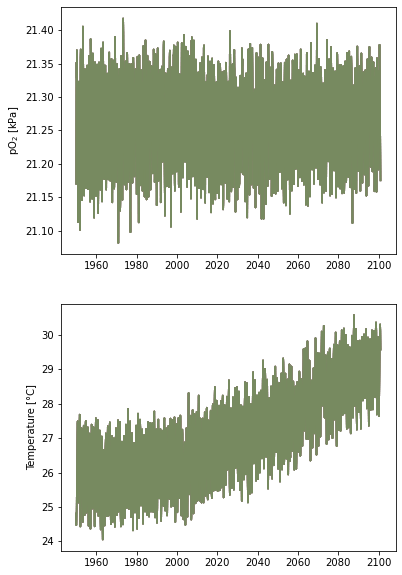

In [23]:
fig, axs = plt.subplots(2, 1, figsize=(6, 10))

for member_id in ds.member_id.values:   
    axs[0].plot(yrfrac[tnx], ds.isel(member_id=0, time=tnx).pO2, alpha=0.2)
axs[0].set_ylabel('pO$_2$ [kPa]')
    
for member_id in ds.member_id.values:   
    axs[1].plot(yrfrac[tnx], ds.isel(member_id=0, time=tnx).TEMP, alpha=0.2)
    
axs[1].set_ylabel('Temperature [°C]')    

Text(0, 0.5, 'Std dev Temperature [°C]')

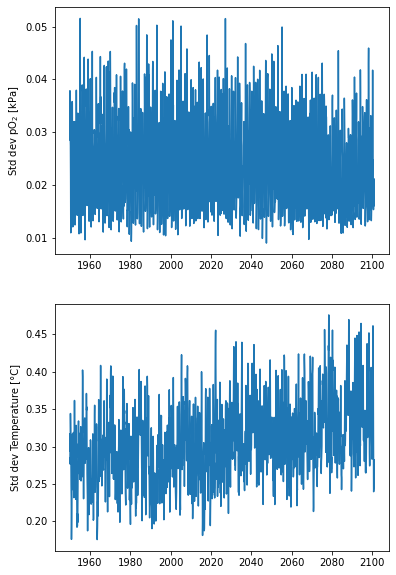

In [25]:
fig, axs = plt.subplots(2, 1, figsize=(6, 10))

axs[0].plot(yrfrac[tnx], ds.isel(time=tnx).std('member_id').pO2)
axs[0].set_ylabel('Std dev pO$_2$ [kPa]')
    
axs[1].plot(yrfrac[tnx], ds.isel(time=tnx).std('member_id').TEMP)
axs[1].set_ylabel('Std dev Temperature [°C]')    
     

In [31]:
tnx_20c = np.where((1950 < yrfrac) & (yrfrac <= 1970))[0]
#tnx_20c = np.where((2081 < yrfrac) & (yrfrac <= 2100))

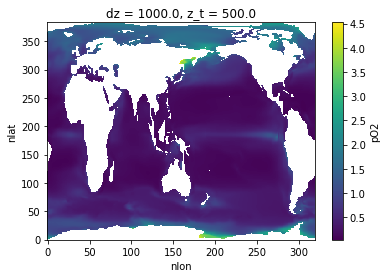

In [32]:
ds_20C = dsets['20C.ocn.pop.h.drift-corrected'].isel(time=tnx_20c, z_t=0).std(['member_id', 'time']).compute()
#ds_RCP = dsets['RCP85.ocn.pop.h.drift-corrected'].isel(z_t=0).sel(time=slice('2081', '2100')).std(['member_id', 'time']).compute() 

ds_20C.pO2.plot()

In [36]:
year = [d.year for d in dsets['RCP85.ocn.pop.h.drift-corrected'].time.values]
month = [d.month for d in dsets['RCP85.ocn.pop.h.drift-corrected'].time.values]
day = [d.day for d in dsets['RCP85.ocn.pop.h.drift-corrected'].time.values]
yrfrac_rcp = year_frac(year, month, day)

tnx_rcp = np.where((2081 < yrfrac_rcp) & (yrfrac_rcp <= 2100))[0]

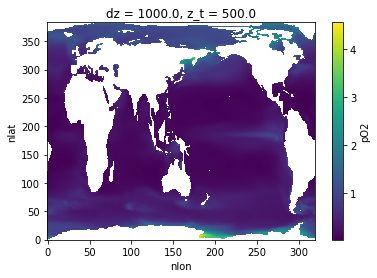

In [37]:
ds_RCP = dsets['RCP85.ocn.pop.h.drift-corrected'].isel(time=tnx_rcp, z_t=0).std(['member_id', 'time']).compute()
#ds_RCP = dsets['RCP85.ocn.pop.h.drift-corrected'].isel(z_t=0).sel(time=slice('2081', '2100')).std(['member_id', 'time']).compute() 

ds_RCP.pO2.plot()

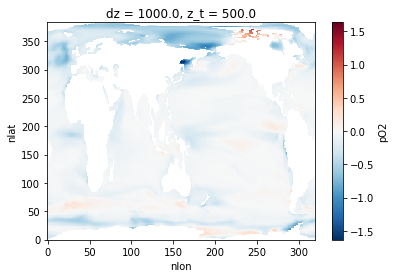

In [38]:
(ds_RCP.pO2 - ds_20C.pO2).plot()

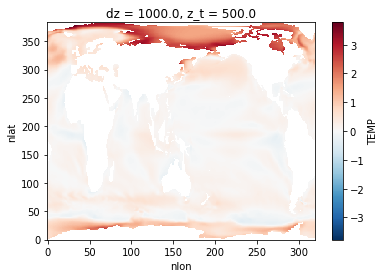

In [39]:
(ds_RCP.TEMP - ds_20C.TEMP).plot()